In [5]:
# auto-reload modules when they have changed
%reload_ext autoreload
%autoreload 2

In [34]:
from modules.analyze.blob_detection import BlobDetector
from modules.load import image
from config import config as cfg

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from skimage import img_as_ubyte, exposure, filters, measure

from tabulate import tabulate
import scrapbook as sb

In [7]:
SOURCE_IMAGE_PATH = "/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_09/77K-33nM-eGFP-vitrified/20uW/images/img_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_20uW_77K_circpol_006.img"

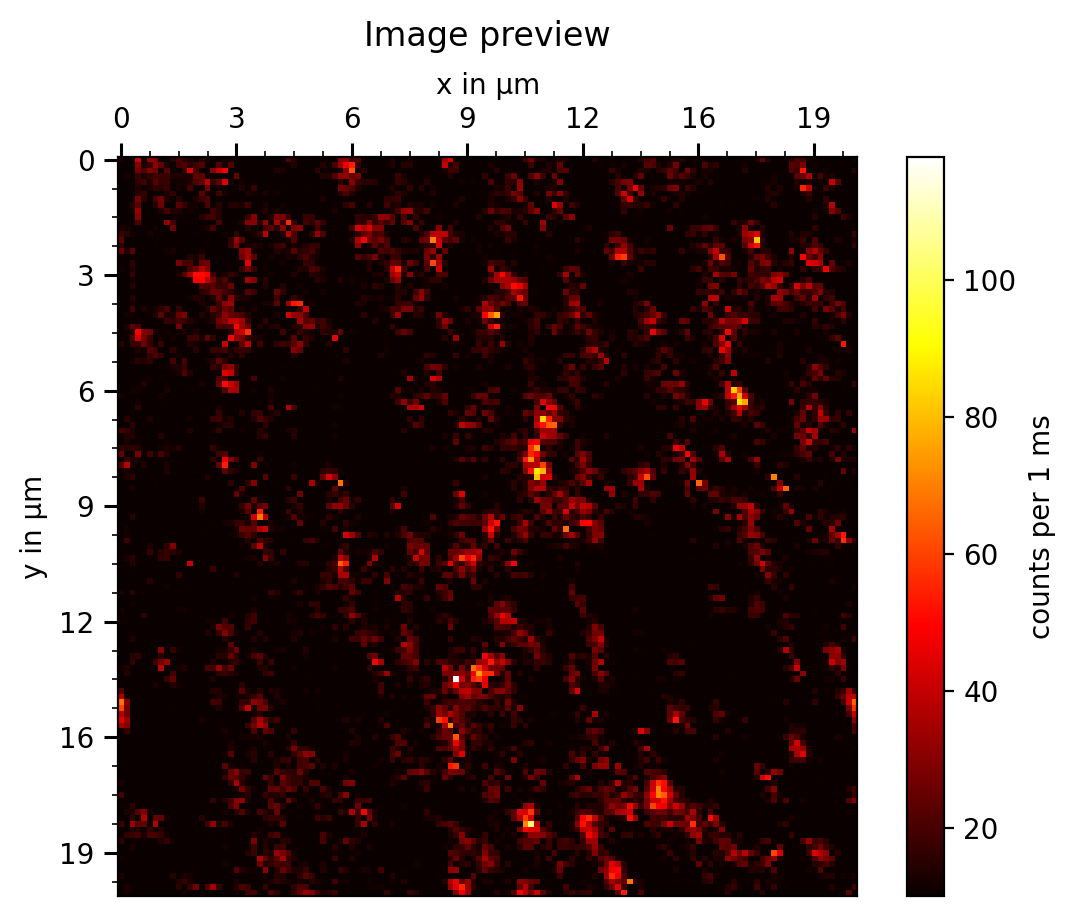

Data (arrays) in image file:
  - preview : (128, 128), int64


-----------------------------------------------------------------------------
file name: img_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_20uW_77K_circpol_006.img
-----------------------------------------------------------------------------
file size: 65592 bytes
header:
{'dwelltime': 0.001,
 'offset_x': 7.999999999999999e-05,
 'offset_y': 9.999999999999999e-05,
 'pixel_x': 128,
 'pixel_y': 128,
 'range_x': 1.9999999999999998e-05,
 'range_y': 1.9999999999999998e-05}


In [8]:
# Load image
im = image.load_from_path(SOURCE_IMAGE_PATH)
im.preview(vmin=10)
im.info()


In [9]:
image = im.data['preview']

min_intensity = np.amin(image)
max_intensity = np.amax(image)
median_intensity = np.median(image)

# Print the different intensity values
print('Minimum intensity: ', min_intensity)
print('Maximum intensity: ', max_intensity)
print('Median intensity:  ', int(median_intensity))


Minimum intensity:  0
Maximum intensity:  118
Median intensity:   8


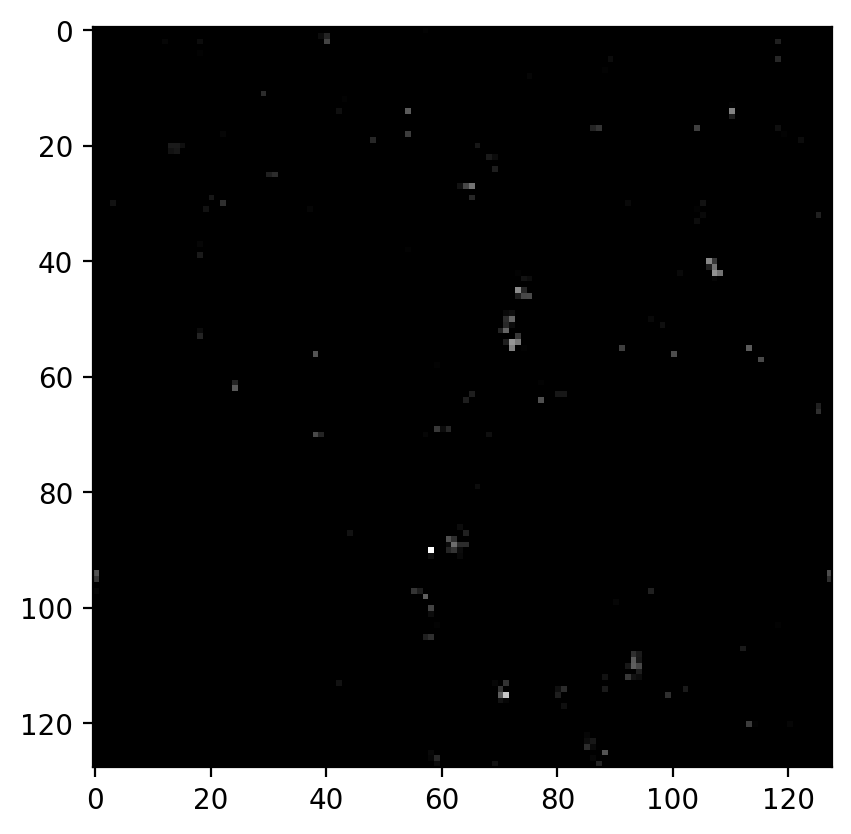

In [10]:
# Convert image to PIL Image object
#pil_img = Image.fromarray((image * 255).astype(np.uint8))
#pil_img = Image.fromarray(img_as_ubyte(image))
pil_img = Image.fromarray(image.astype(np.uint8))

# Convert image to grayscale
gray_img = pil_img.convert("L")

# Convert grayscale image back to numpy array
gray_arr = np.array(gray_img)

# Scale values in gray_arr to range from 0 to 255
scaled_arr = ((gray_arr - np.min(gray_arr)) / (np.max(gray_arr) - np.min(gray_arr))) * 255

# Convert scaled_arr to uint8
scaled_arr = scaled_arr.astype(np.uint8)

# Display image
plt.imshow(scaled_arr, cmap="gray", vmin=93, vmax=np.max(scaled_arr))
plt.show()

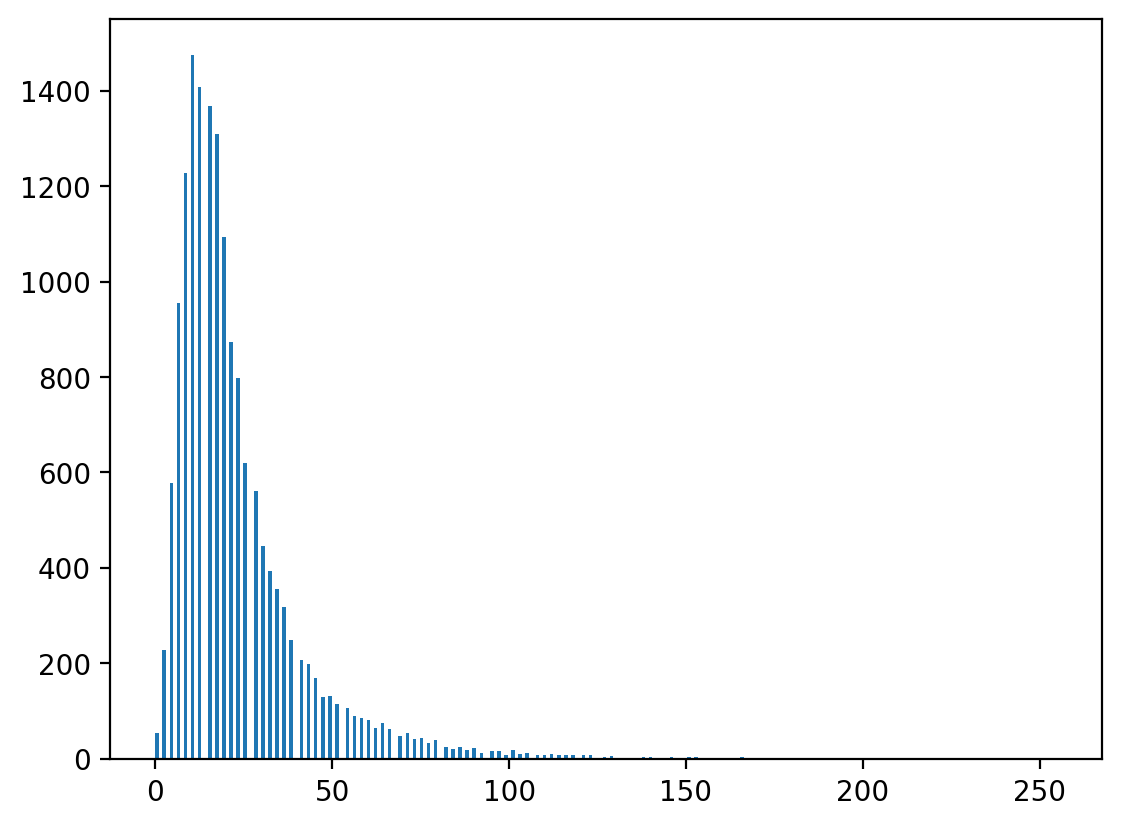

In [11]:
# Create histogram of greyscale values of image
hist = plt.hist(scaled_arr.ravel(),  bins=256, range=(0, 255))

# Limit y axis to 0-1000
#plt.ylim(0, 100)

plt.show()

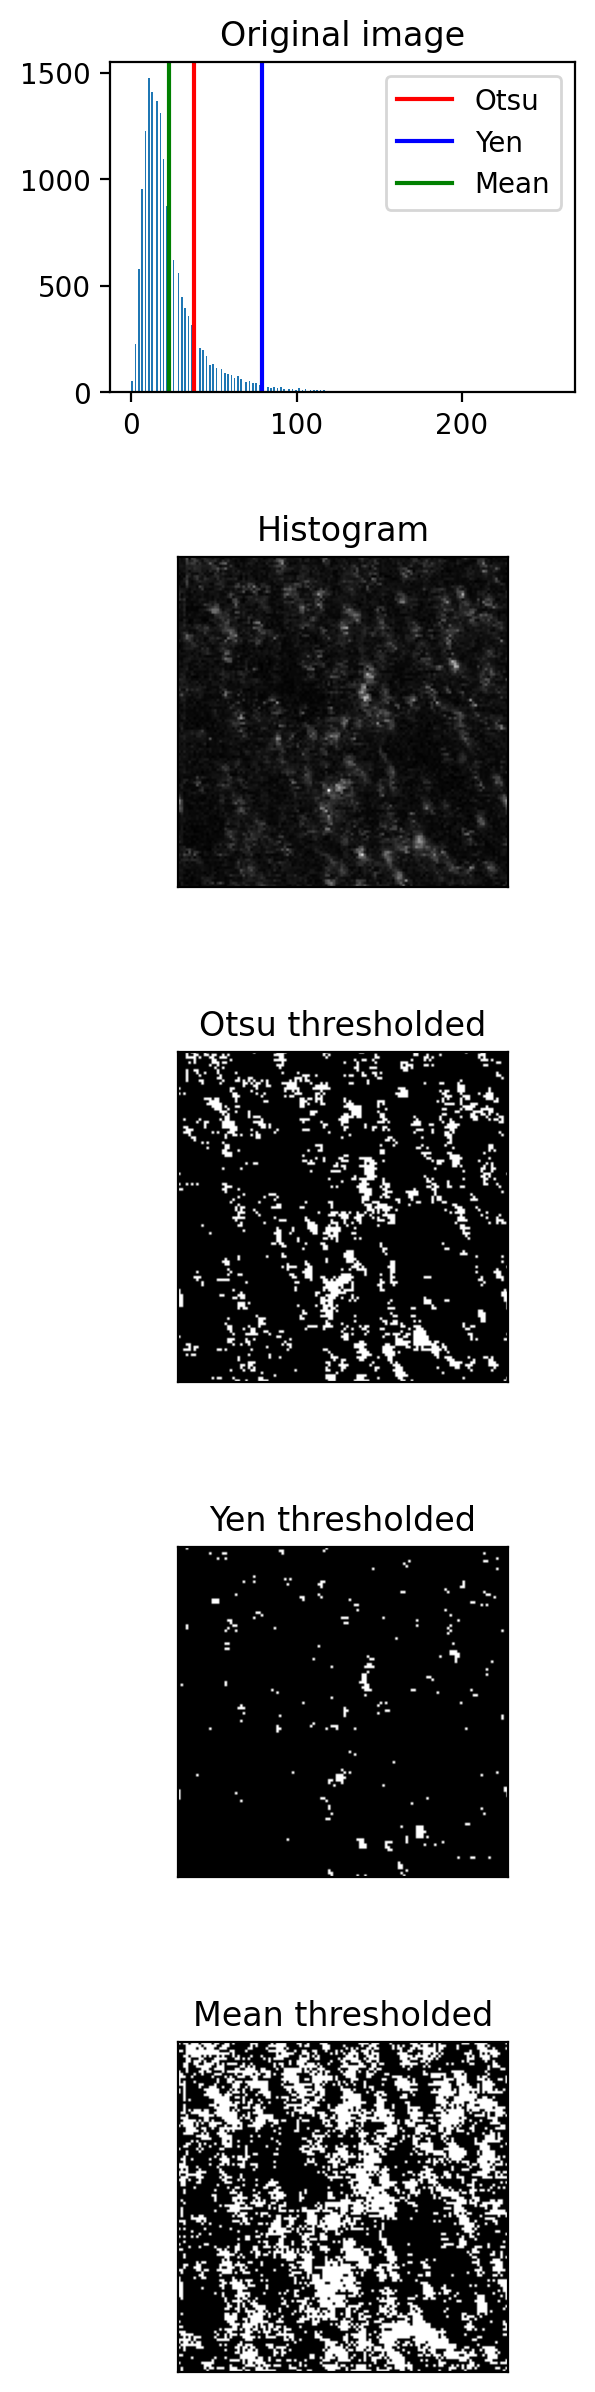

Threshold Otsu: 38
Threshold Yen: 79
Threshold mean: 22.49371337890625
Normalized threshold Otsu: 0.14901960784313725
Normalized threshold Yen: 0.30980392156862746
Normalized threshold mean: 0.08821064070159314


In [12]:
# Calculate threshold using Otsu's method
threshold_otsu = filters.threshold_otsu(scaled_arr)

# Calculate threshold using Yen's method
threshold_yen = filters.threshold_yen(scaled_arr)

# Calculate threshold using mean method
threshold_mean = np.mean(scaled_arr)

# Create a figure with three subplots, first row is original image, second row is histogram, third row is the two thresholded images
fig, axes = plt.subplots(nrows=5, figsize=(3,15))


# Plot histogram in the second subplot
axes[0].hist(scaled_arr.ravel(), bins=256, range=(0, 256))
axes[0].axvline(x=threshold_otsu, color='r')
axes[0].axvline(x=threshold_yen, color='b')
axes[0].axvline(x=threshold_mean, color='g')
axes[0].legend(('Otsu', 'Yen', 'Mean'))

# Plot original image in the first subplot
axes[1].imshow(scaled_arr, cmap='gray')


# Plot thresholded images in the third row next to each other
axes[2].imshow(scaled_arr > threshold_otsu, cmap='gray')
axes[3].imshow(scaled_arr > threshold_yen, cmap='gray')
axes[4].imshow(scaled_arr > threshold_mean, cmap='gray')

# Set title for the original image
axes[0].title.set_text('Original image')

# Set title for the histogram
axes[1].title.set_text('Histogram')

# Set titles for the thresholded images
axes[2].title.set_text('Otsu thresholded')
axes[3].title.set_text('Yen thresholded')
axes[4].title.set_text('Mean thresholded')

# Remove x and y ticks for the subplots except the histogram
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[4].set_xticks([])
axes[4].set_yticks([])

# Add space between histogram and the other subplots
plt.subplots_adjust(hspace=0.5)

# Show the figure
plt.show()

# Compute normalized thresholds
normalized_threshold_otsu = threshold_otsu / 255
normalized_threshold_yen = threshold_yen / 255
normalized_threshold_mean = threshold_mean / 255

# Print out the threshold values
print('Threshold Otsu: {}'.format(threshold_otsu))
print('Threshold Yen: {}'.format(threshold_yen))
print('Threshold mean: {}'.format(threshold_mean))

# Print out normalized values
print('Normalized threshold Otsu: {}'.format(normalized_threshold_otsu))
print('Normalized threshold Yen: {}'.format(normalized_threshold_yen))
print('Normalized threshold mean: {}'.format(normalized_threshold_mean))


In [13]:
#img = scaled_arr
#fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
#plt.show()

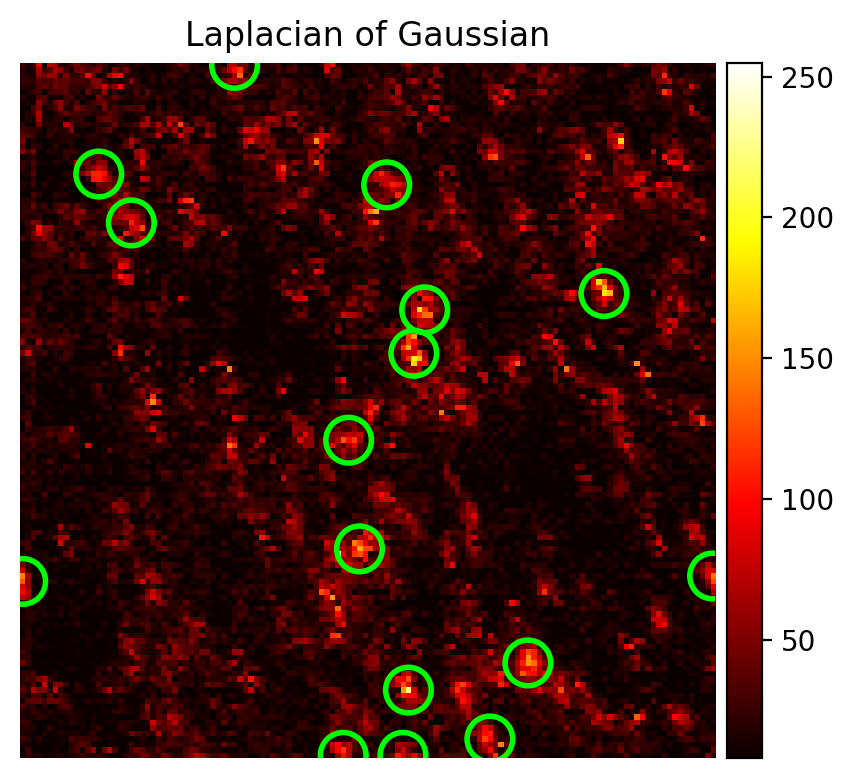

In [14]:
# Initialize blob detector
bd = BlobDetector(input_image=scaled_arr, blob_type='log')

# Detect blobs
blobs = bd.detect_blobs(min_sigma=3, max_sigma=5, num_sigma=50, threshold=normalized_threshold_mean);

# Plot blobs on image
bd.plot_blobs(blobs, vmin=np.median(image))


In [15]:
print(blobs)
blob_data = blobs

[[110.  93.   3.]
 [ 42. 107.   3.]
 [ 95.   0.   3.]
 [ 89.  62.   3.]
 [ 53.  72.   3.]
 [115.  71.   3.]
 [ 94. 127.   3.]
 [ 45.  74.   3.]
 [  0.  39.   3.]
 [127.  59.   3.]
 [ 22.  67.   3.]
 [ 20.  14.   3.]
 [124.  86.   3.]
 [127.  70.   3.]
 [ 29.  20.   3.]
 [ 69.  60.   3.]]


In [16]:
blobs_log = blob_data
blobs = []

#image_array = im.data['APD1'] + im.data['APD2']
image_array = im.data['preview']

for blob in blobs_log:
    # Get blob coordinates and radius
    y, x, r = blob

    # Extract blob pixels from original image
    blob_pixels = image_array[int(y - r):int(y + r), int(x - r):int(x + r)]

    if blob_pixels.shape[0] == blob_pixels.shape[1]: 
        blobs.append(blob_pixels)
    else:
        pass



In [17]:
# Create list to store average intensities
avg_intensities = []
max_intensities = []

# Loop over blobs and plot in subplots
for i, blob in enumerate(blobs):
    # Calculate average intensity
    avg_intensity = np.mean(blob)

    # Calculate max intensity
    max_intensity = np.max(blob)

    avg_intensities.append(avg_intensity)
    max_intensities.append(max_intensity)

# Calculate histogram parameters
r_avg_intensities = [round(intensity) for intensity in avg_intensities]
r_max_intensities = [round(intensity) for intensity in max_intensities]

print(r_avg_intensities)
print(r_max_intensities)

[35, 30, 34, 36, 29, 30, 25, 22, 25, 25, 25]
[71, 86, 75, 87, 102, 84, 52, 51, 68, 57, 60]


In [41]:
blob_data = []
for i, blob in enumerate(blobs):
    blob_data.append(['blob_{}'.format(i+1), r_avg_intensities[i], r_max_intensities[i]])

print(blob_data)

# Convert blob_data to a dataframe
blob_dataframe = pd.DataFrame(blob_data)

# Set the column names
blob_dataframe.columns = ['ID', 'Avg. intensity', 'Max. intensity']

# Add a column that contains the file name for each blob (i.e. the file name of the image that was analyzed)
blob_dataframe['File'] = os.path.basename(SOURCE_IMAGE_PATH)

# Make 'File' the first column
cols = blob_dataframe.columns.tolist()
cols = cols[-1:] + cols[:-1]
blob_dataframe = blob_dataframe[cols]


# Print the table using the tabulate function
print(tabulate(blob_data, headers=['ID', 'Avg.\nintensity', 'Max.\nintensity'], tablefmt='rst'))

[['blob_1', 35, 71], ['blob_2', 30, 86], ['blob_3', 34, 75], ['blob_4', 36, 87], ['blob_5', 29, 102], ['blob_6', 30, 84], ['blob_7', 25, 52], ['blob_8', 22, 51], ['blob_9', 25, 68], ['blob_10', 25, 57], ['blob_11', 25, 60]]
=======  ===========  ===========
ID              Avg.         Max.
           intensity    intensity
=======  ===========  ===========
blob_1            35           71
blob_2            30           86
blob_3            34           75
blob_4            36           87
blob_5            29          102
blob_6            30           84
blob_7            25           52
blob_8            22           51
blob_9            25           68
blob_10           25           57
blob_11           25           60
=======  ===========  ===========


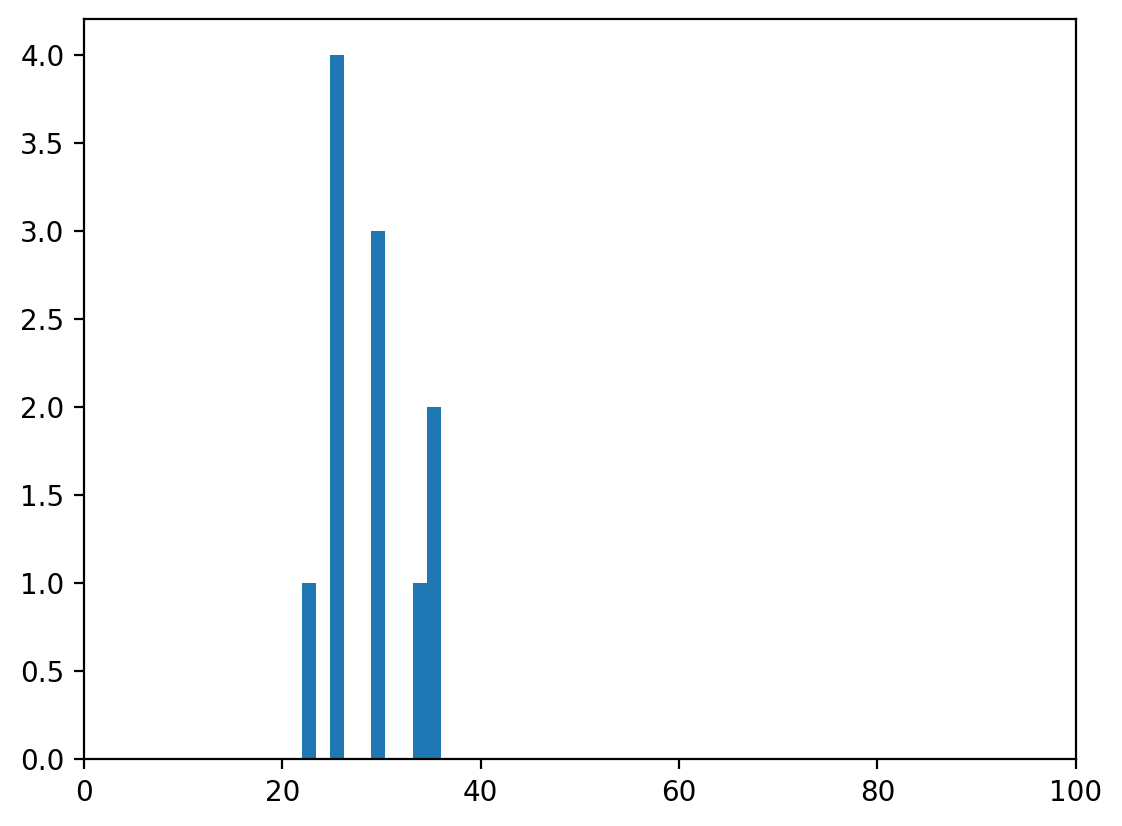

In [19]:
plt.hist(r_avg_intensities)
plt.xlim(0, 100)
plt.show()

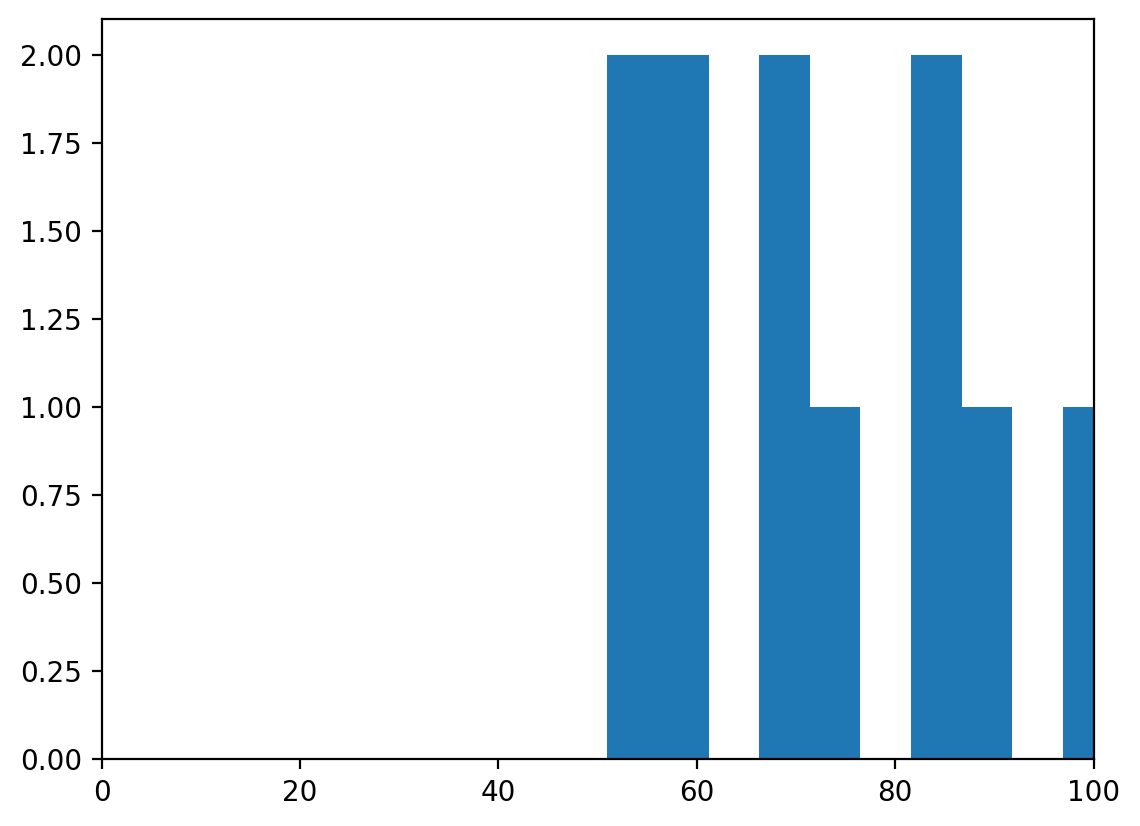

In [26]:
plt.hist(r_max_intensities)
plt.xlim(0, 100)
plt.show()

In [43]:
# Save blob_data to scrapbook
#sb.glue('blob_data', blob_data)
#sb.glue('message', 'Hello from scrapbook!')
sb.glue('blob_dataframe', blob_dataframe)

blob_dataframe.head()

,File,ID,Avg. intensity,Max. intensity
0,img_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_20uW...,blob_1,35,71
1,img_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_20uW...,blob_2,30,86
2,img_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_20uW...,blob_3,34,75
3,img_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_20uW...,blob_4,36,87
4,img_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_20uW...,blob_5,29,102
